# *Importing Libraries:*

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import concatenate, Dense, BatchNormalization, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adamax, Nadam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# *Preprocessing:*

In [3]:
dataset_path = '/kaggle/input/nose-dataset/Dataset'

paths = []
labels = []

for category in ['normal', 'fracture']:
    category_path = os.path.join(dataset_path, category)
    
    for folder_name in os.listdir(category_path):
        folder_path = os.path.join(category_path, folder_name)
        
        if os.path.isdir(folder_path):
            for image_name in ['R', 'L']:
                image_path = os.path.join(folder_path, f'{image_name}.jpg')
                
                if os.path.exists(image_path):
                    paths.append(image_path)
                    labels.append(category)

                    
df = pd.DataFrame({'image_path': paths, 'label': labels})
df.head()

,image_path,label
0,/kaggle/input/nose-dataset/Dataset/normal/1402...,normal
1,/kaggle/input/nose-dataset/Dataset/normal/1402...,normal
2,/kaggle/input/nose-dataset/Dataset/normal/1402...,normal
3,/kaggle/input/nose-dataset/Dataset/normal/1402...,normal
4,/kaggle/input/nose-dataset/Dataset/normal/1401...,normal


In [4]:
df.shape

(2968, 2)

In [5]:
def read_images_from_df(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = row['image_path']
        if row['label'] == "normal":
            label = 0
        else: label = 1
        img = cv2.imread(img_path)
        img = img[:img.shape[1], :]
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

images, labels = read_images_from_df(df)

In [7]:
def sharpen_image(image, kernel_size=(3, 3), strength=0.5):
    kernel = np.array([[0, -1, 0],
                       [-1, 4, -1],
                       [0, -1, 0]])

    sharpened = cv2.filter2D(image, -1, kernel)

    sharpened = cv2.addWeighted(image, 1 + strength, sharpened, -strength, 0)

    return sharpened

In [8]:
def preprocessing(img):
    img = img[:img.shape[1], :]
    
    img = cv2.resize(img, (224,224), interpolation=cv2.INTER_AREA)
    
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
    cl1 = clahe.apply(gray_image)
    
    rgb = cv2.cvtColor(cl1, cv2.COLOR_GRAY2RGB)
    
    return rgb

In [9]:
for i in range (len(images)):
    images[i] = preprocessing(images[i])

In [10]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [11]:
batch_size = 32

one_hot_label = to_categorical(labels)

X_train, X_val_test, y_train, y_val_test = train_test_split(np.asarray(images), np.asarray(one_hot_label), 
                                                            test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.66, random_state=42)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    brightness_range=[0.8, 1.3],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(rescale=1./255) 

test_datagen = ImageDataGenerator(rescale=1./255) 



# Create generator for training data
train_generator = train_datagen.flow(
    np.array(X_train), 
    y_train, 
    batch_size=batch_size,
    shuffle=True,
)

# Create generator for Validation data
validation_generator = validation_datagen.flow(
    np.array(X_val),
    y_val,
    batch_size=batch_size,
    shuffle=False,  
)

# Create generator for Test data
test_generator = test_datagen.flow(
    np.array(X_test),
    y_test,
    batch_size=batch_size,
    shuffle=False,  
)

In [12]:
print("shape of X_train is: {} ".format(X_train.shape))
print("shape of X_val is: {}".format(X_val.shape))
print("shape of X_test is: {}".format(X_test.shape))

shape of X_train is: (2077, 224, 224, 3) 
shape of X_val is: (302, 224, 224, 3)
shape of X_test is: (589, 224, 224, 3)


In [13]:
classes = np.unique(y_train)
classes

array([0., 1.], dtype=float32)

In [14]:
img, lable = validation_generator.next()
img.shape

(32, 224, 224, 3)

### Show sample:

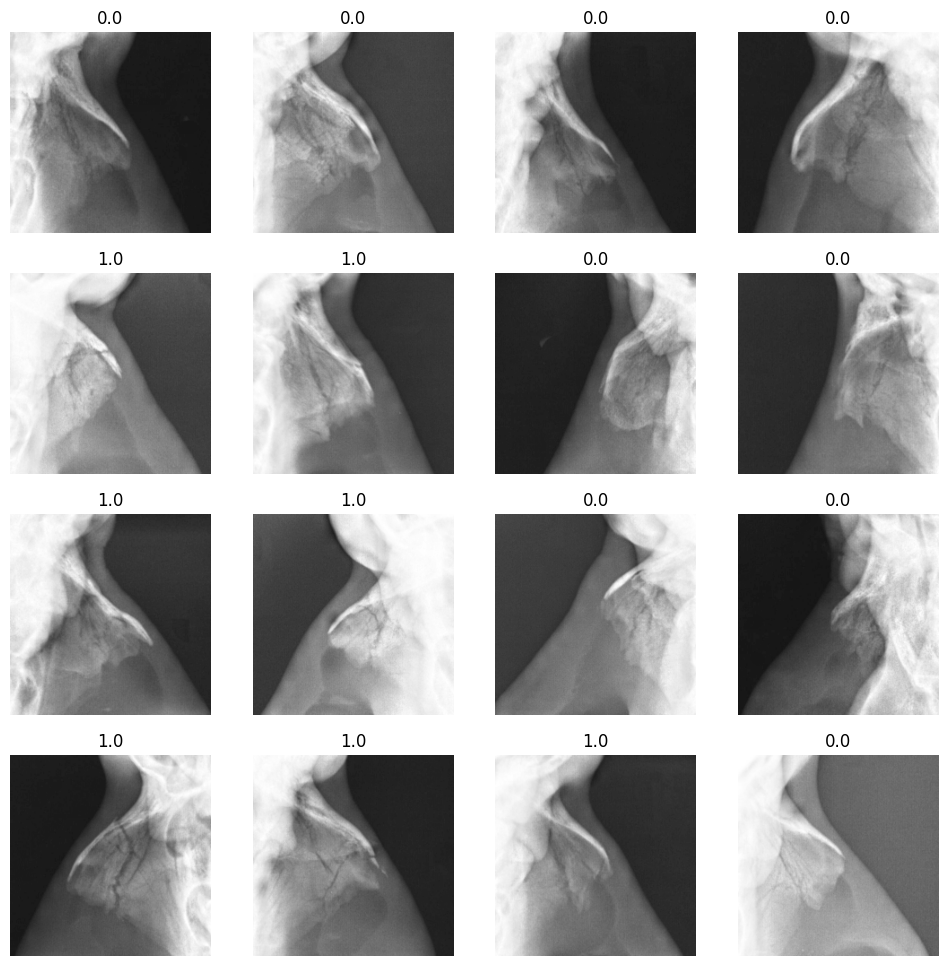

In [15]:
def show_sample(img, lable):
    plt.figure(figsize= (12, 12))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img[i])
        index = np.argmax(lable[i]) 
        class_name = classes[index]
        plt.title(class_name)
        plt.axis('off')
    plt.show()
    
show_sample(img, lable)

In [16]:
def draw_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, axis = plt.subplots(1, 2, figsize=(15,6))
    axis[0].set_title('Training & validation accuracy', fontsize = 15, fontweight = 'bold')
    axis[0].plot(acc, label='training accuracy', color='darkblue')
    axis[0].plot(val_acc, label='validation accuracy', color='deeppink')
    axis[0].legend()
    axis[1].set_title('Training & validation loss', fontsize = 15, fontweight = 'bold')
    axis[1].plot(loss, label='training loss', color='darkblue')
    axis[1].plot(val_loss, label='validation loss', color='deeppink')
    axis[1].legend()
    
    print("Maximum Accuracy of Training set: {:.3f}\nMinimum Loss of Trainig set: {:.8f}\n".format(np.max(acc)*100, np.min(loss)))
    print("Maximum Accuracy of Validation set: {:.3f}\nMinimum Loss of Validation set: {:.8f}\n".format(np.max(val_acc)*100, np.min(val_loss))) 

# *Model Structure:*

In [19]:
# global parameters:
EPOCHS = 50
IMG_SHAPE = (224, 224, 3)
LR = 5e-4
OPTIMIZER = tf.keras.optimizers.legacy.Adamax(LR)
LOSS = CategoricalCrossentropy()
METRICS = ['accuracy']

In [20]:
def lr_schedule(epoch):
    initial_learning_rate = LR
    decay = 0.98
    lr = initial_learning_rate * decay**(1.25 * epoch)
    if lr > 1e-4:
        return lr
    else:
        return 1e-4

In [21]:
lr_scheduler = LearningRateScheduler(lr_schedule)

## *Convolutional Neural Network:*
#### *Using Transfer Learning...*

In [22]:
from tensorflow.keras.applications import ResNet101V2, Xception, InceptionResNetV2, DenseNet121

### DenseNet121

In [23]:
expert1 = DenseNet121(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

expert1.trainable = True
print("Number of layers in the expert1: ", len(expert1.layers))

for layer in expert1.layers[:int(len(expert1.layers) * 0.3)]:
    layer.trainable = False

29084464/29084464 [==============================] - 0s 0us/step
Number of layers in the expert1:  427


### ResNet101V2

In [24]:
expert2 = ResNet101V2(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

expert2.trainable = True
print("Number of layers in the expert2: ", len(expert2.layers))

for layer in expert2.layers[:int(len(expert2.layers) * 0.3)]:
    layer.trainable = False

171317808/171317808 [==============================] - 1s 0us/step
Number of layers in the expert2:  377


### InceptionResNetV2

In [25]:
expert3 = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

expert3.trainable = True
print("Number of layers in the expert3: ", len(expert3.layers))

for layer in expert3.layers[:int(len(expert3.layers) * 0.3)]:
    layer.trainable = False

219055592/219055592 [==============================] - 1s 0us/step
Number of layers in the expert3:  780


### Xception

In [26]:
expert4 = Xception(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

expert4.trainable = True
print("Number of layers in the expert4: ", len(expert4.layers))

for layer in expert4.layers[:int(len(expert4.layers) * 0.3)]:
    layer.trainable = False

83683744/83683744 [==============================] - 0s 0us/step
Number of layers in the expert4:  132


In [28]:
def build_model(input_shape):
    input_img = tf.keras.Input(shape=input_shape)
    
    # DenseNet121
    conv1 = expert1(input_img)
    flat1 = Flatten()(conv1)
    drop1_1 = Dropout(0.5)(flat1)
    bn1_1 = BatchNormalization()(drop1_1)
    dense1_1 = Dense(256, 'relu')(bn1_1)
    drop1_2 = Dropout(0.5)(dense1_1)
    bn1_2 = BatchNormalization()(drop1_2)
    
    dense1_2 = Dense(64, 'relu')(bn1_2)
    drop1_3 = Dropout(0.3)(dense1_2)
    bn1_3 = BatchNormalization()(drop1_3)

    # ResNet101V2
    conv2 = expert2(input_img)
    flat2 = Flatten()(conv2)
    drop2_1 = Dropout(0.5)(flat2)
    bn2_1 = BatchNormalization()(drop2_1)
    dense2_1 = Dense(256, 'relu')(bn2_1)
    drop2_2 = Dropout(0.5)(dense2_1)
    bn2_2 = BatchNormalization()(drop2_2)
    
    dense2_2 = Dense(64, 'relu')(bn2_2)
    drop2_3 = Dropout(0.3)(dense2_2)
    bn2_3 = BatchNormalization()(drop2_3)

    # InceptionResNetV2
    conv3 = expert3(input_img)
    flat3 = Flatten()(conv3)
    drop3_1 = Dropout(0.5)(flat3)
    bn3_1 = BatchNormalization()(drop3_1)
    dense3_1 = Dense(256, 'relu')(bn3_1)
    drop3_2 = Dropout(0.5)(dense3_1)
    bn3_2 = BatchNormalization()(drop3_2)
    
    dense3_2 = Dense(64, 'relu')(bn3_2)
    drop3_3 = Dropout(0.3)(dense3_2)
    bn3_3 = BatchNormalization()(drop3_3)

    # Xception
    conv4 = expert4(input_img)
    flat4 = Flatten()(conv4)
    drop4_1 = Dropout(0.5)(flat4)
    bn4_1 = BatchNormalization()(drop4_1)
    dense4_1 = Dense(256, 'relu')(bn4_1)
    drop4_2 = Dropout(0.5)(dense4_1)
    bn4_2 = BatchNormalization()(drop4_2)
    
    dense4_2 = Dense(64, 'relu')(bn4_2)
    drop4_3 = Dropout(0.3)(dense4_2)
    bn4_3 = BatchNormalization()(drop4_3)


    merged = concatenate([bn1_3, bn2_3, bn3_3, bn4_3])
    
    
    # Output
    dense1_out = Dense(64, 'relu')(merged)
    drop1_out = Dropout(0.4)(dense1_out)
    bn1_out = BatchNormalization()(drop1_out)
    dense2_out = Dense(16, 'relu')(bn1_out)
    drop2_out = Dropout(0.3)(dense2_out)
    bn2_out = BatchNormalization()(drop2_out)
    
    output = Dense(len(classes), activation='softmax')(bn2_out)

    model = tf.keras.Model(inputs=input_img, outputs=output)

    return model

model = build_model(IMG_SHAPE)
model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet121 (Functional)    (None, 7, 7, 1024)           7037504   ['input_5[0][0]']             
                                                                                                  
 resnet101v2 (Functional)    (None, 7, 7, 2048)           4262656   ['input_5[0][0]']             
                                                          0                                       
                                                                                                  
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)           5433673   ['input_5[0][0]']         

In [30]:
len(model.trainable_variables)

995

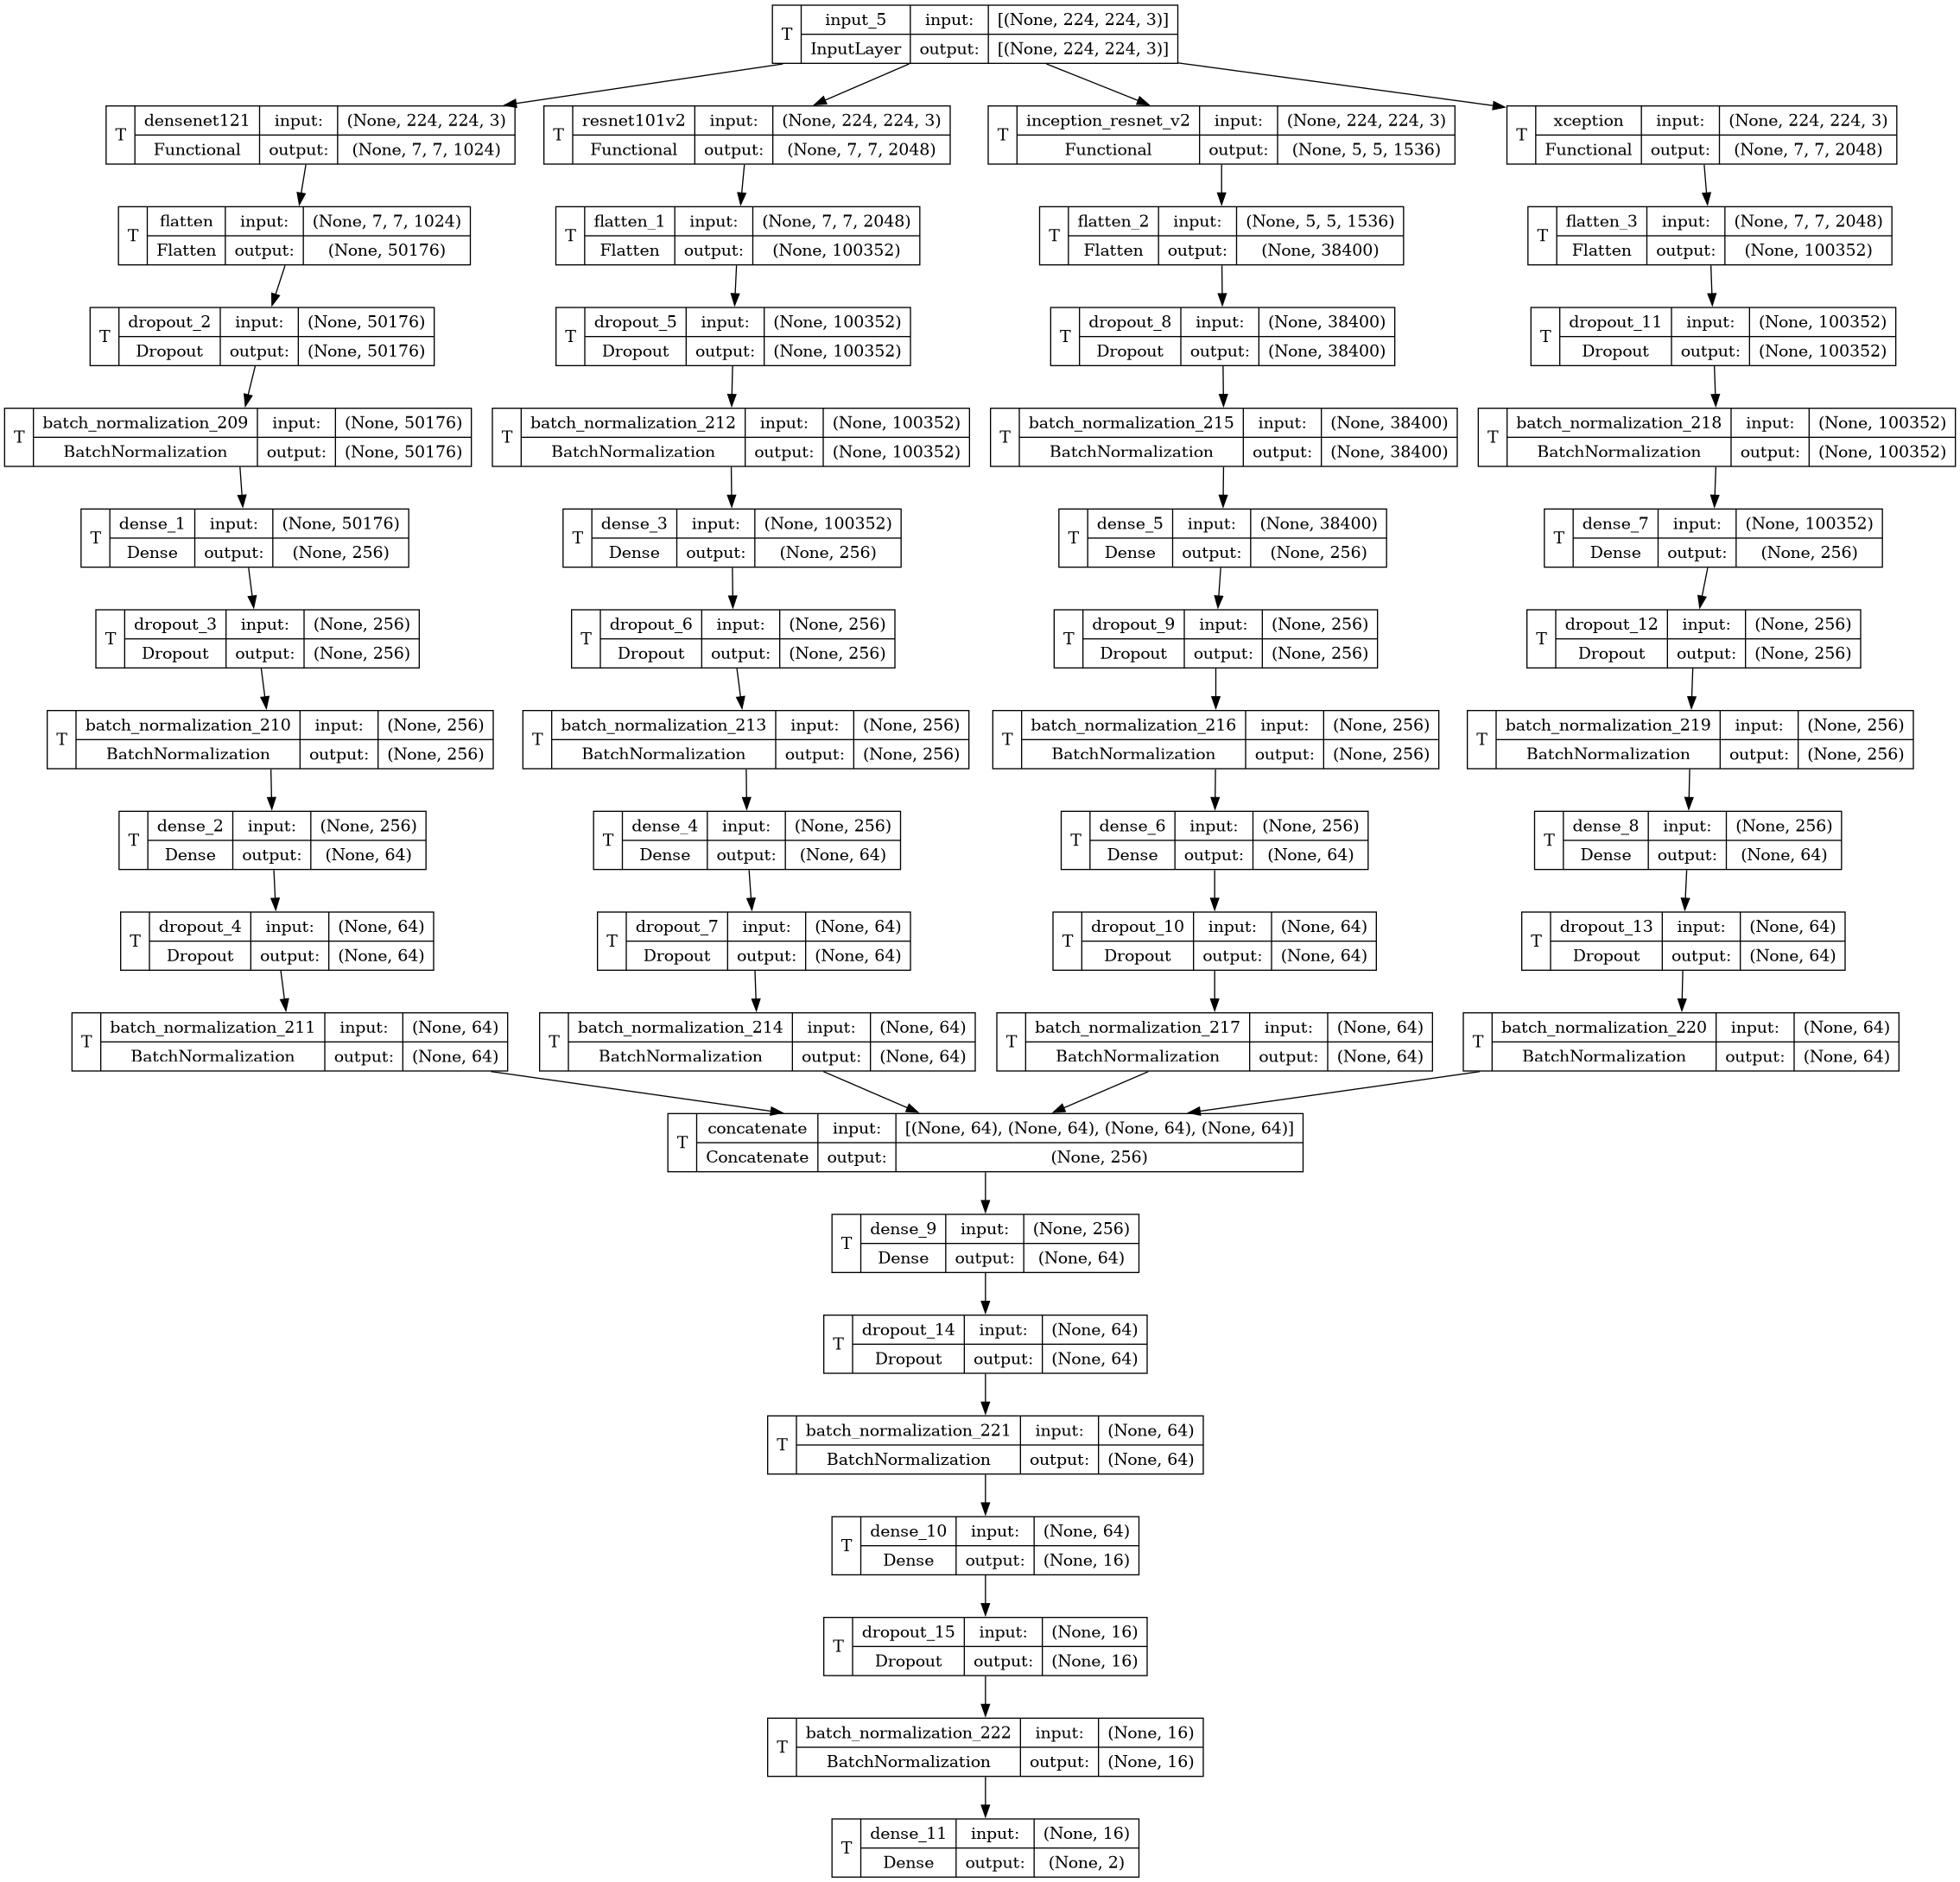

In [31]:
plot_model(model, show_shapes = True, show_trainable = True)

In [32]:
hist = model.fit(train_generator, validation_data = validation_generator, epochs = EPOCHS, callbacks=[lr_scheduler])

Epoch 1/50
65/65 [==============================] - 126s 1s/step - loss: 0.8333 - accuracy: 0.5060 - val_loss: 0.9937 - val_accuracy: 0.4901 - lr: 5.0000e-04
Epoch 2/50
65/65 [==============================] - 52s 794ms/step - loss: 0.8100 - accuracy: 0.5089 - val_loss: 0.9516 - val_accuracy: 0.4967 - lr: 4.8753e-04
Epoch 3/50
65/65 [==============================] - 52s 794ms/step - loss: 0.8140 - accuracy: 0.5026 - val_loss: 0.7841 - val_accuracy: 0.5099 - lr: 4.7537e-04
Epoch 4/50
65/65 [==============================] - 52s 794ms/step - loss: 0.7618 - accuracy: 0.5378 - val_loss: 0.6766 - val_accuracy: 0.5828 - lr: 4.6352e-04
Epoch 5/50
65/65 [==============================] - 52s 794ms/step - loss: 0.7363 - accuracy: 0.5479 - val_loss: 0.6473 - val_accuracy: 0.6325 - lr: 4.5196e-04
Epoch 6/50
65/65 [==============================] - 52s 794ms/step - loss: 0.7043 - accuracy: 0.5855 - val_loss: 0.6110 - val_accuracy: 0.6788 - lr: 4.4069e-04
Epoch 7/50
65/65 [========================

Maximum Accuracy of Training set: 96.774
Minimum Loss of Trainig set: 0.11239625

Maximum Accuracy of Validation set: 83.113
Minimum Loss of Validation set: 0.46785030



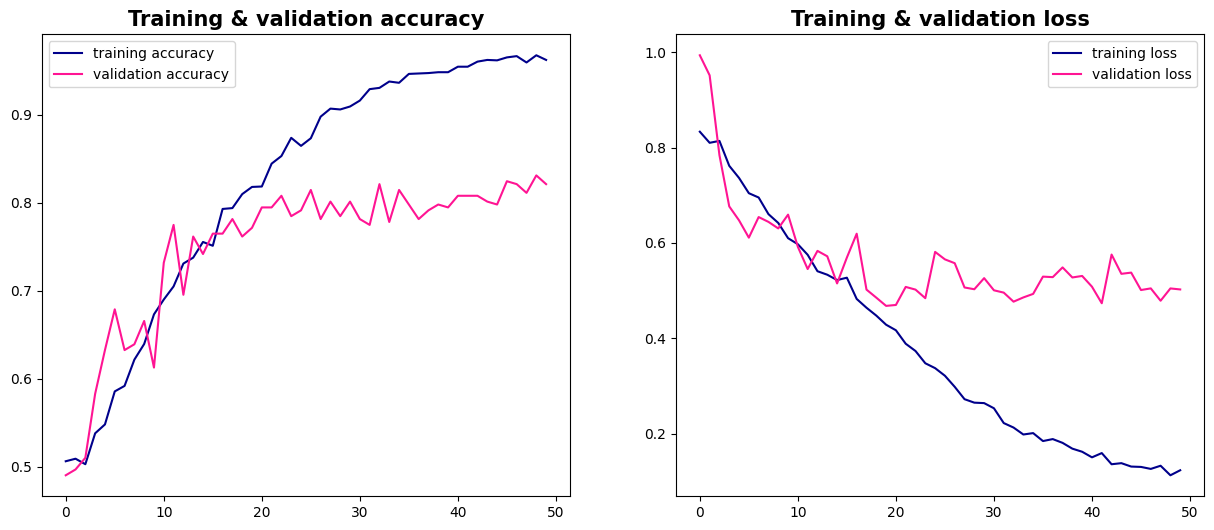

In [40]:
draw_plot(hist)

## *Evaluation:*

In [33]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy * 100)

19/19 [==============================] - 9s 460ms/step - loss: 0.4028 - accuracy: 0.8574
Test accuracy : 85.73853969573975


In [34]:
# Generate predictions
predictions = model.predict(test_generator)

19/19 [==============================] - 15s 307ms/step


In [35]:
y_pred = np.argmax(predictions, axis=1)
y_test = np.argmax(y_test, axis=1)

## *Calculate classification report:*

In [36]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')

Precision: 0.857381
Recall: 0.857385


In [37]:
report = classification_report(y_test, y_pred, target_names=['normal', 'fracture'])
print(report)

              precision    recall  f1-score   support

      normal       0.86      0.86      0.86       301
    fracture       0.86      0.85      0.85       288

    accuracy                           0.86       589
   macro avg       0.86      0.86      0.86       589
weighted avg       0.86      0.86      0.86       589



## *Compute confusion matrix:*

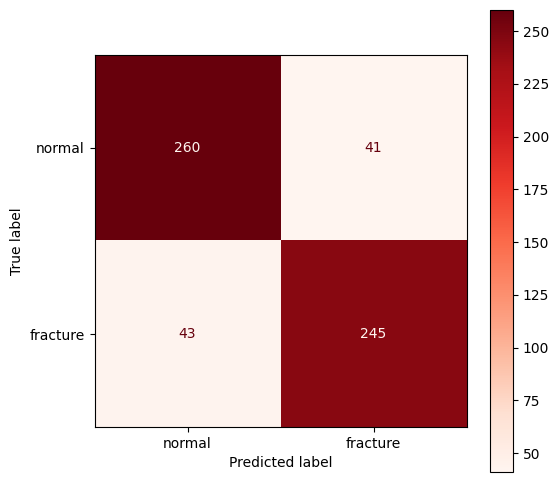

In [38]:
cm = confusion_matrix(y_test, y_pred)

class_labels = ['normal', 'fracture']

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(6, 6))
display.plot(ax=ax, values_format='.4g', cmap='Reds')
plt.show()

In [39]:
from sklearn.metrics import roc_auc_score

# Assuming y_true contains true labels and y_pred contains predicted probabilities
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

AUC: 0.8572409099298635


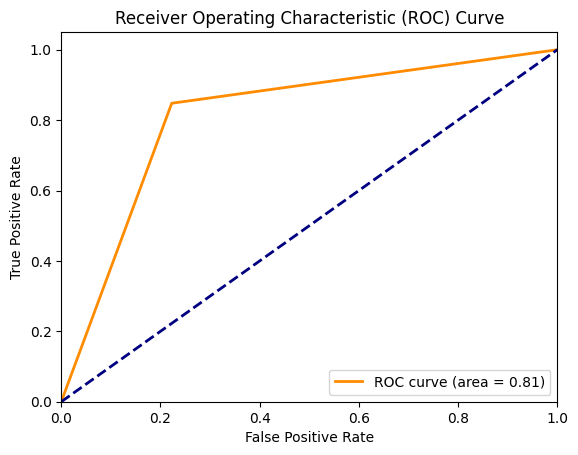

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_true contains true labels and y_pred contains predicted probabilities
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## *Save Model:*

In [ ]:
model.save('model.h5')